In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy.stats
import itertools

2024-02-26 16:01:45.475207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cell_lines = ['PC-3', 'GM12878', 'K562']
model_name = 'enformer'
optimization_name = 'min'
N_iters = 25
_, cre_tiles = utils.set_tile_range(196608, 5000)
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/higher_order_test/')
summary_csv_dir = f'../results/summary_csvs/enformer/greedy_search/'

# Heatmaps of CRE locations

In [23]:
location_maps = pd.read_csv(f"{summary_csv_dir}/{optimization_name}_locations.csv")

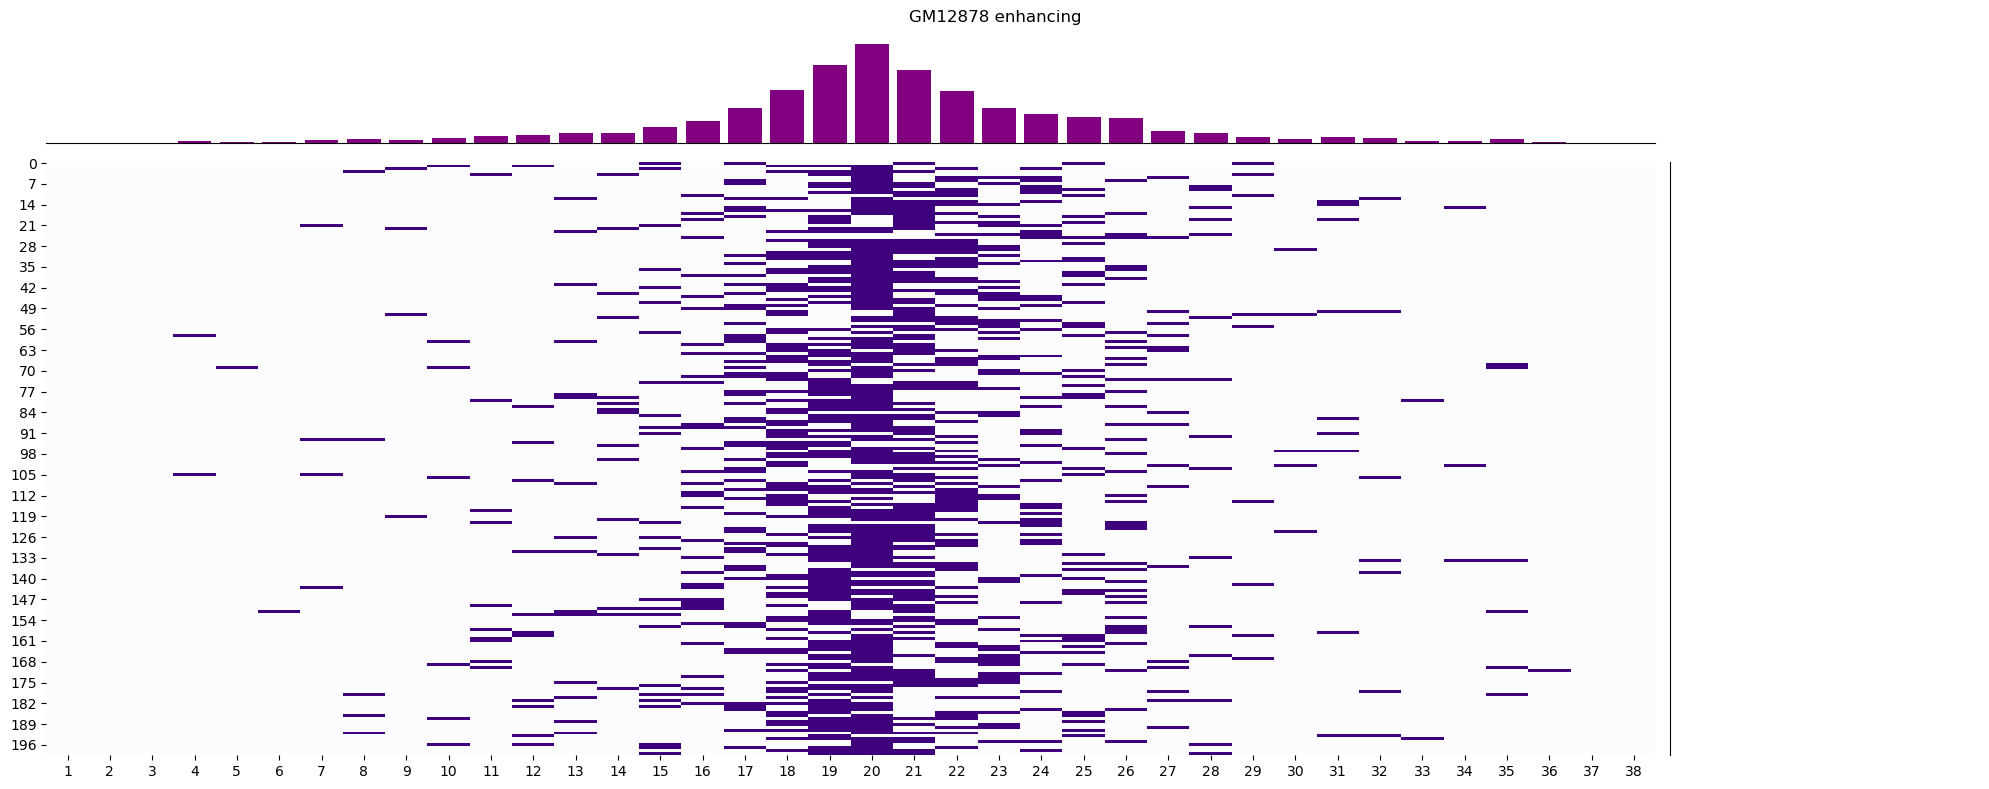

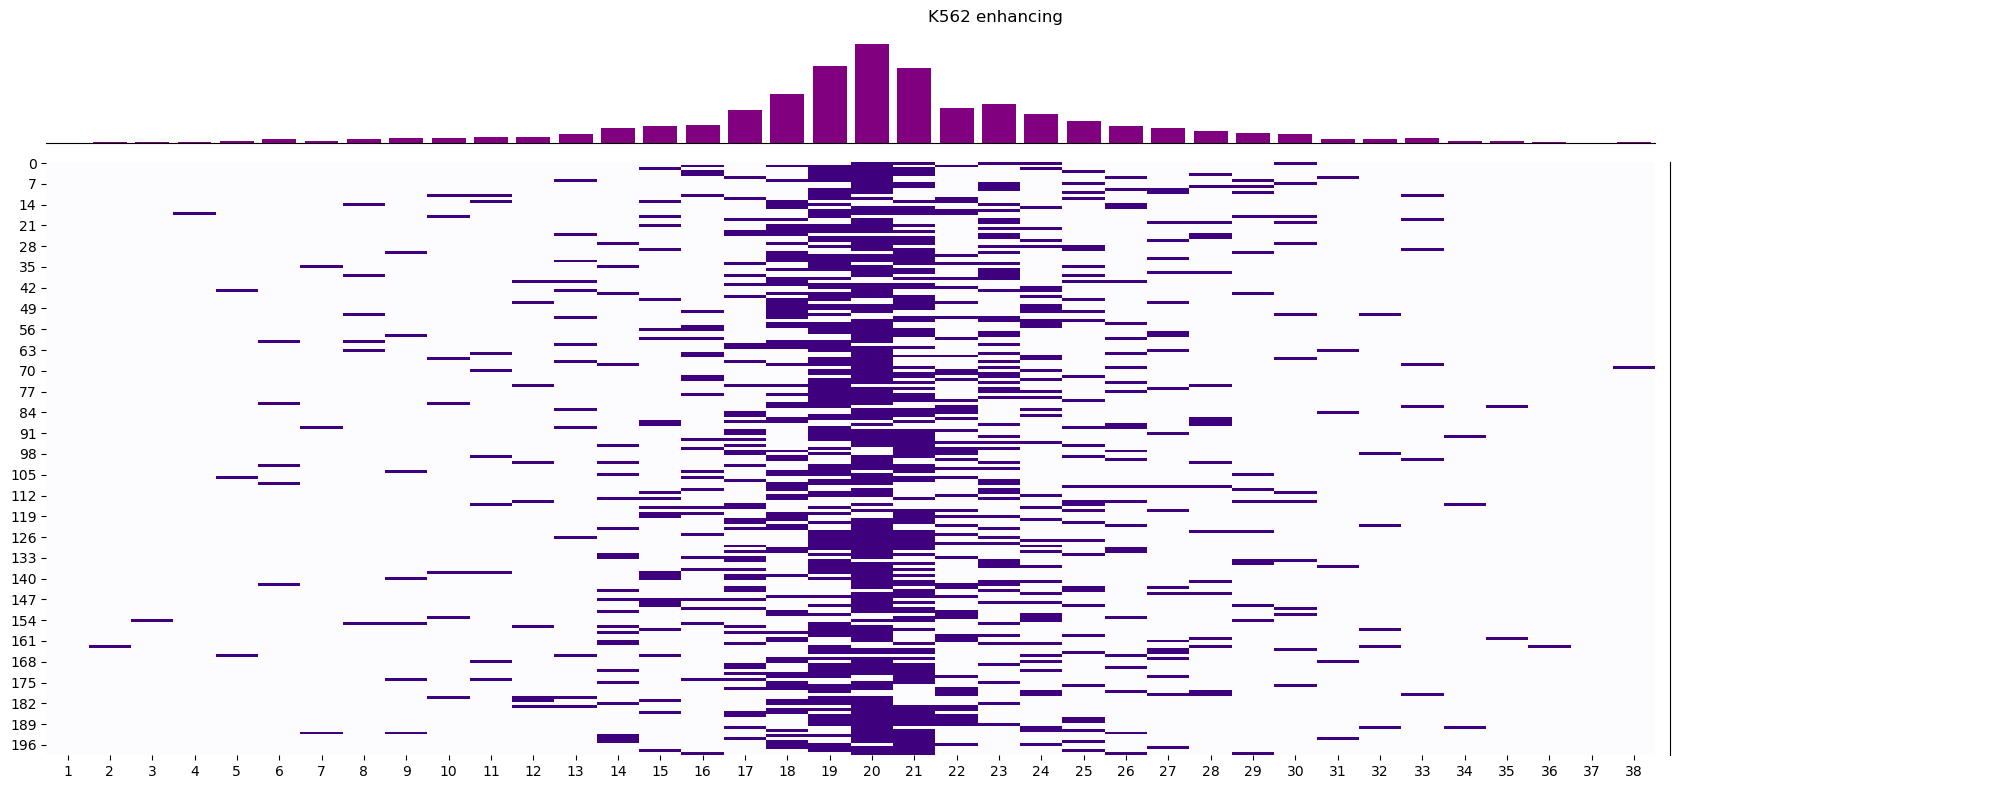

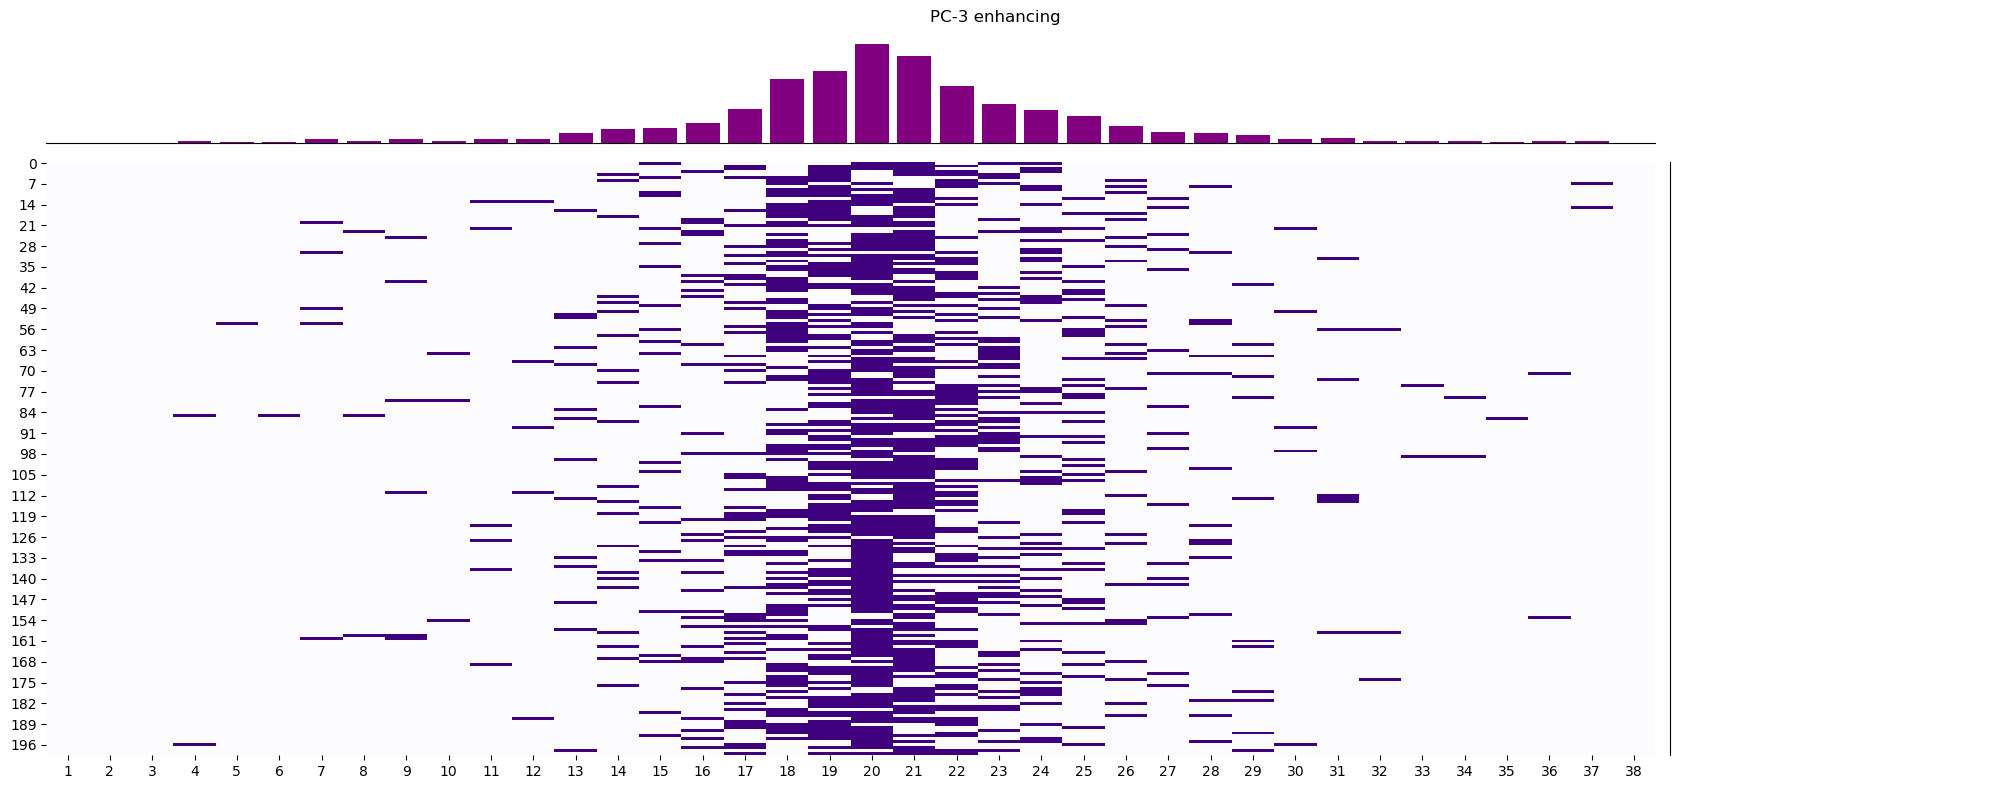

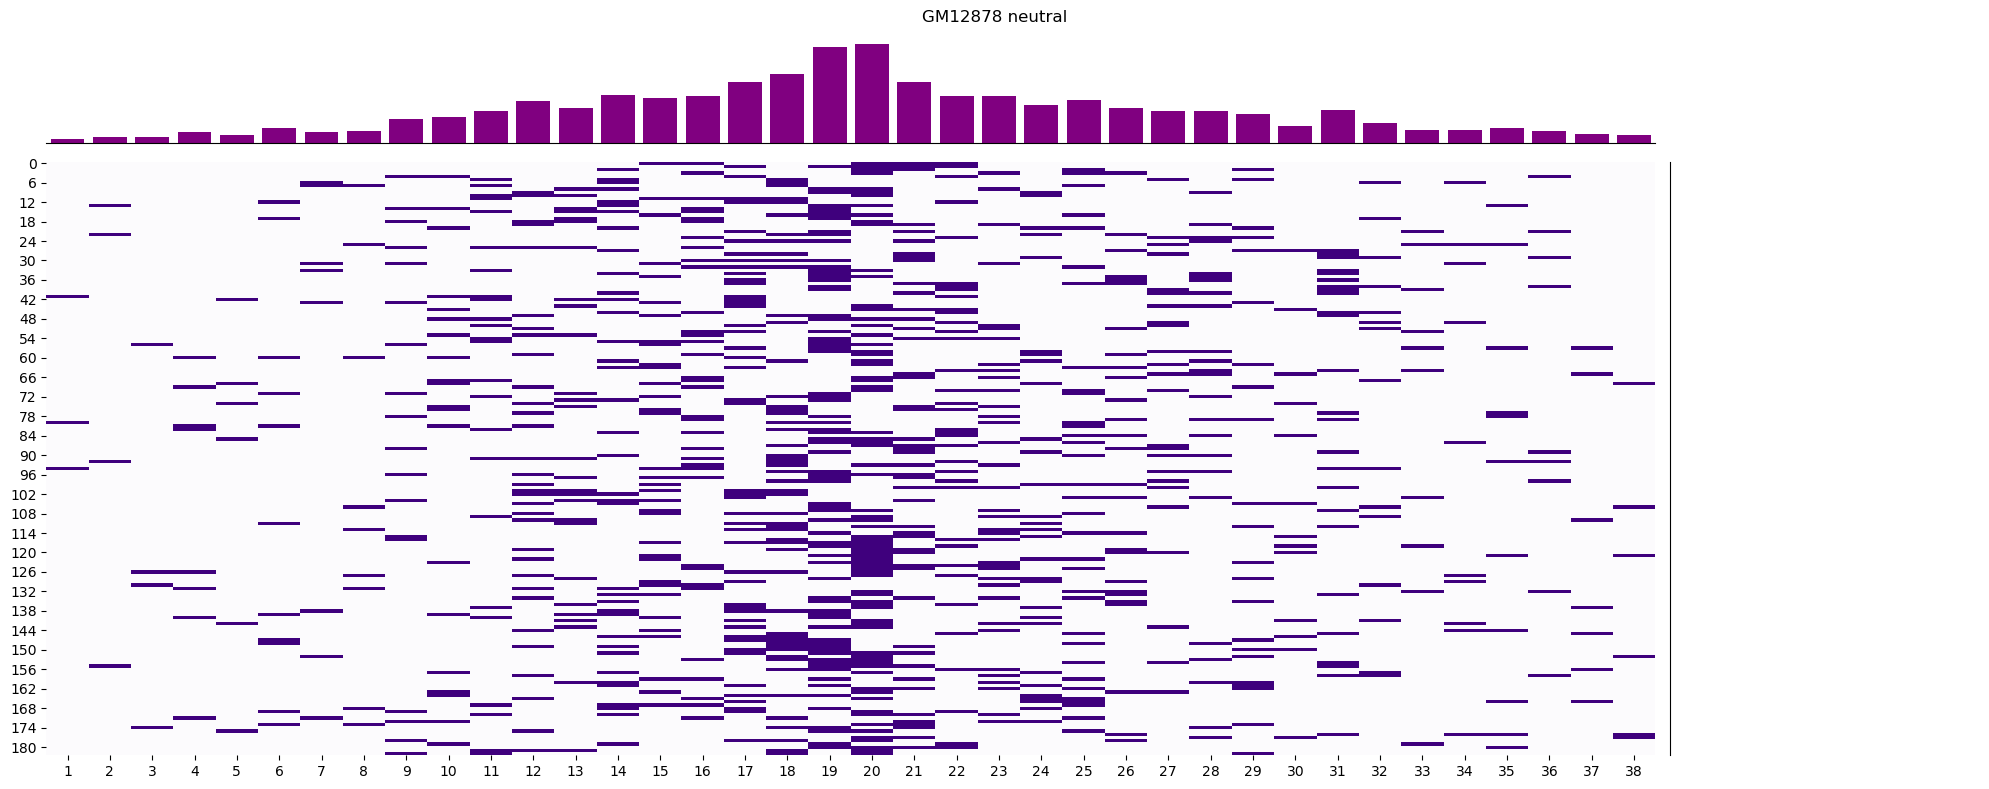

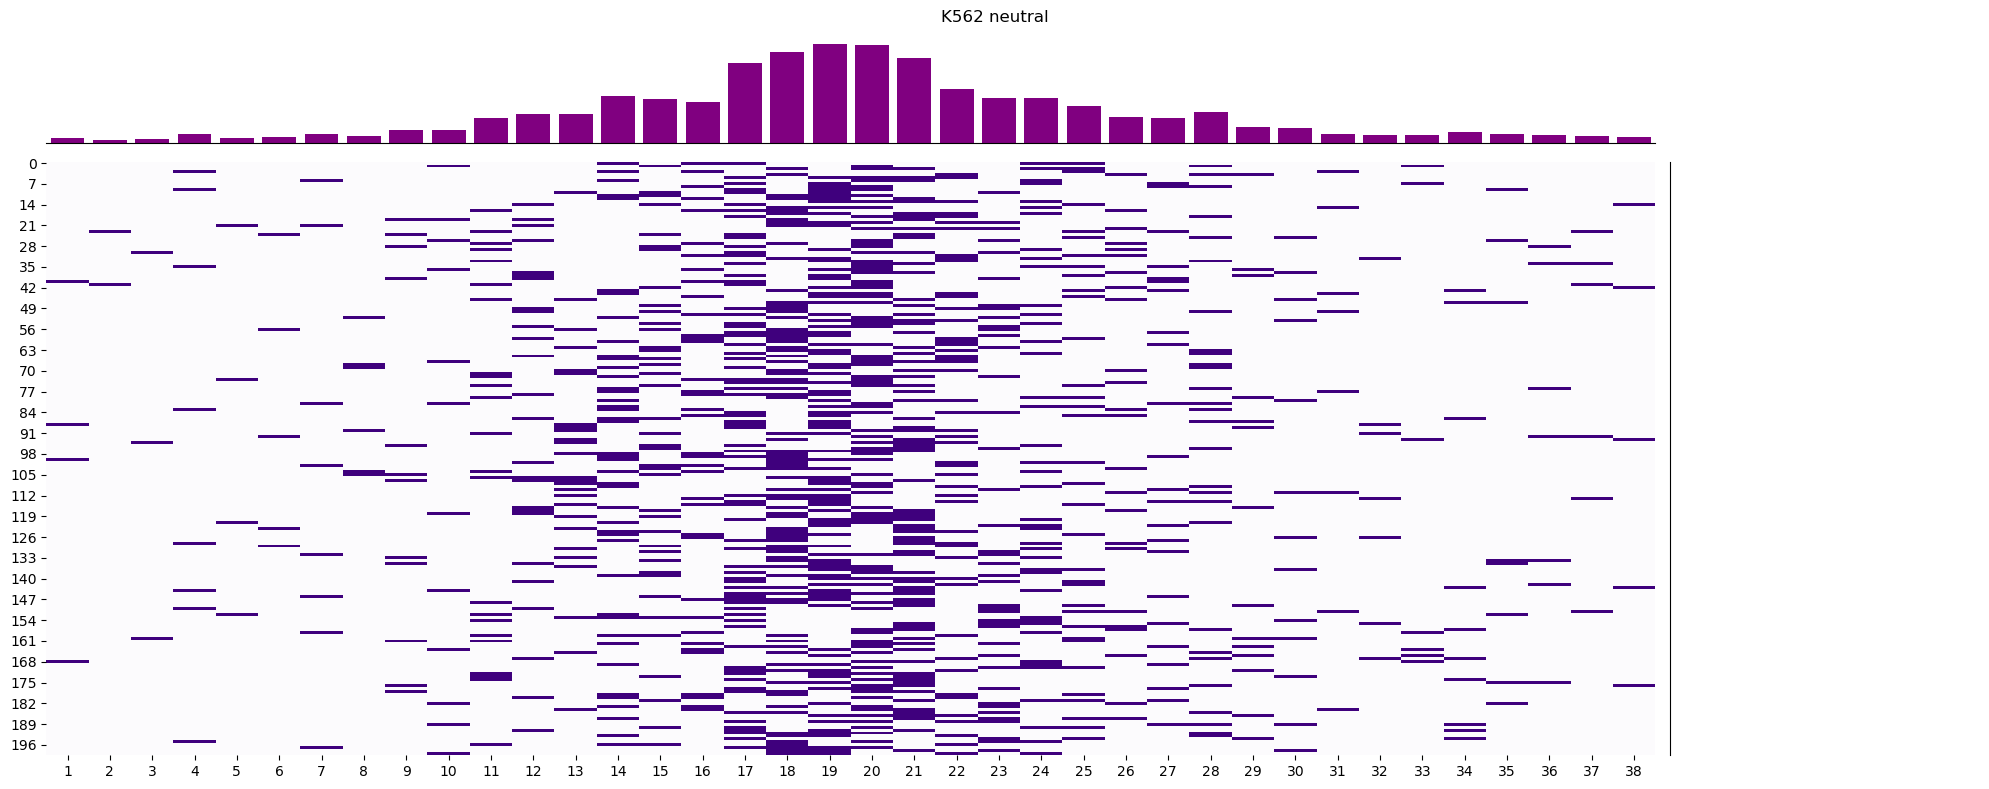

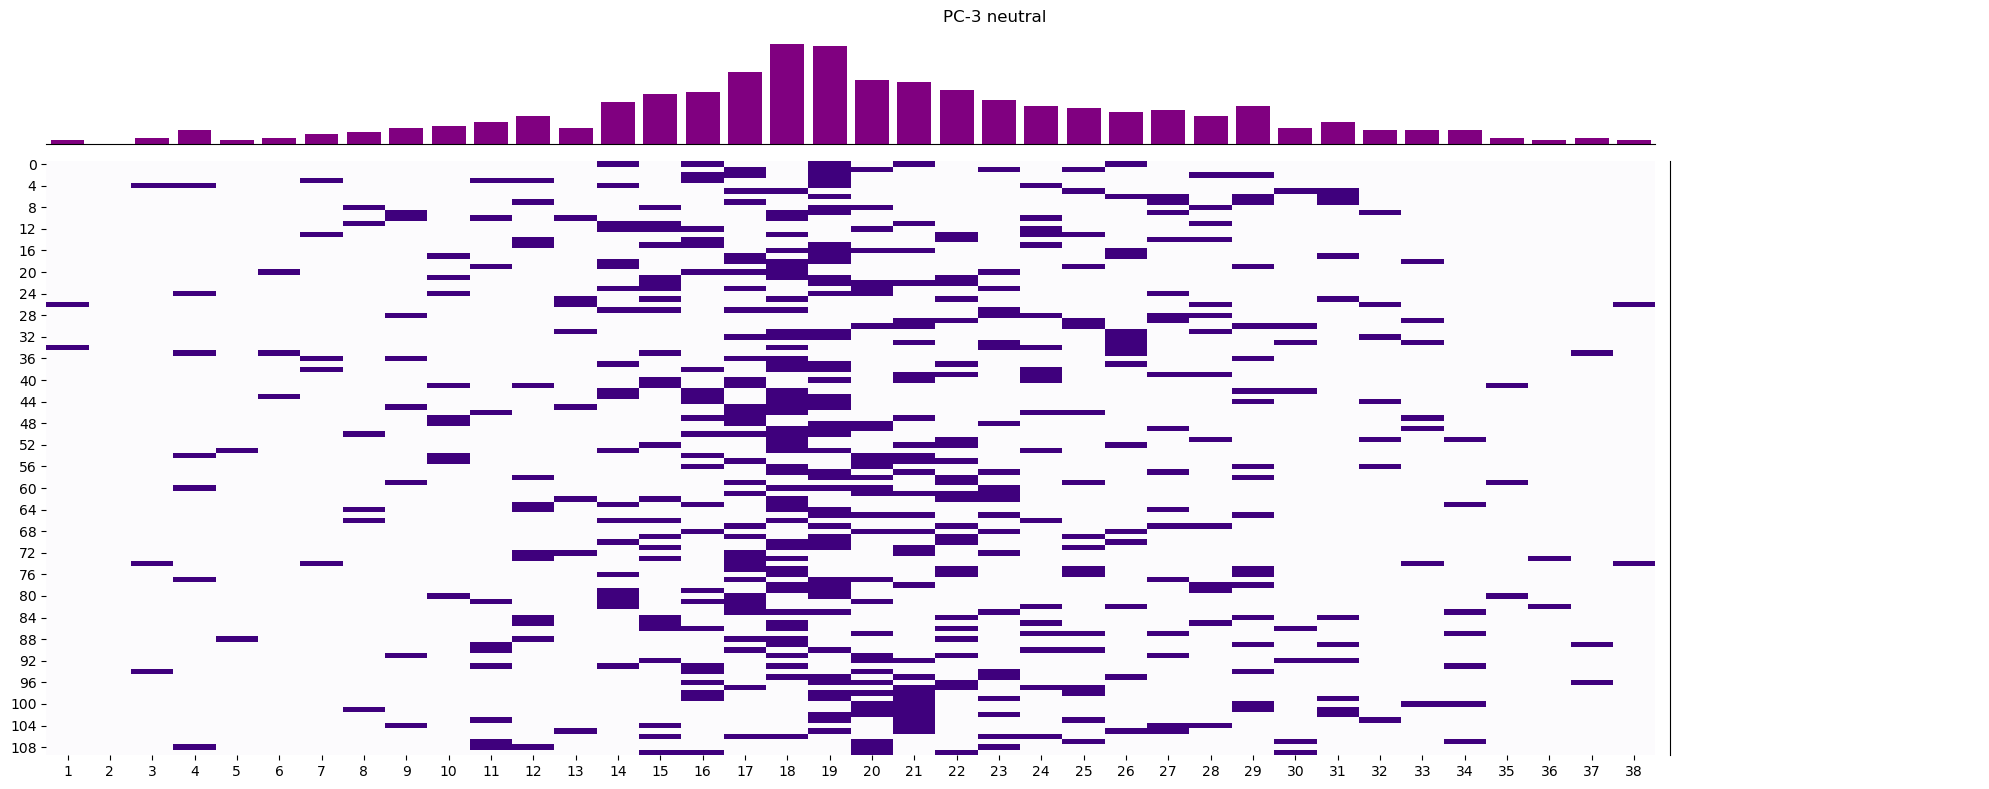

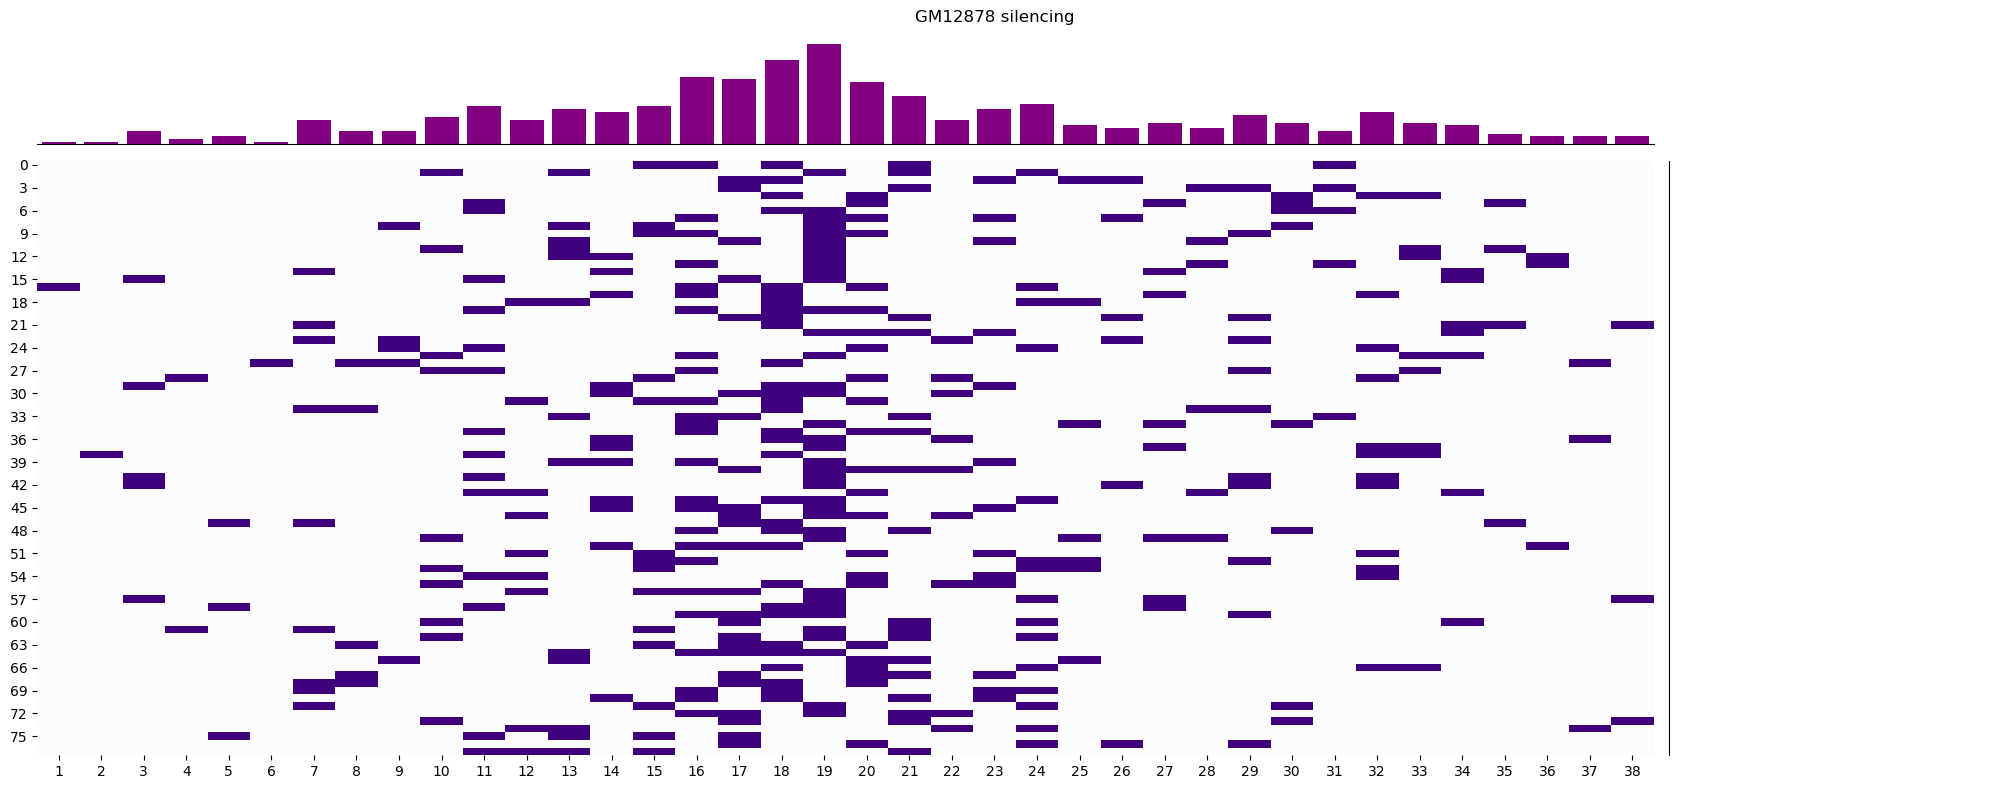

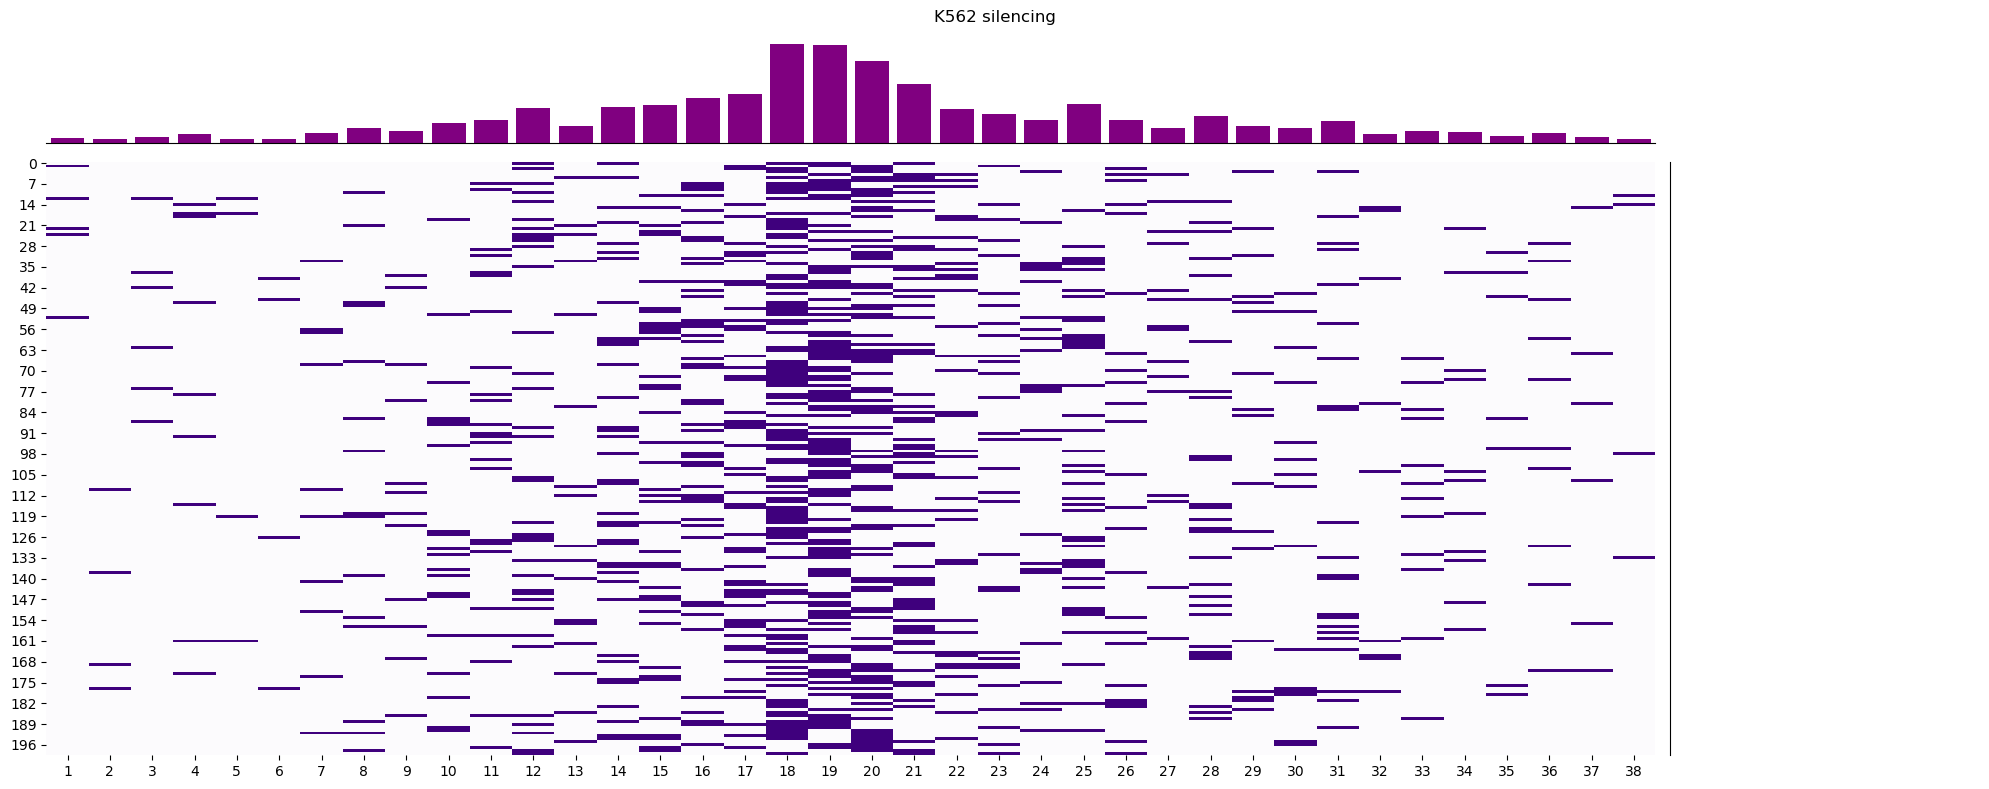

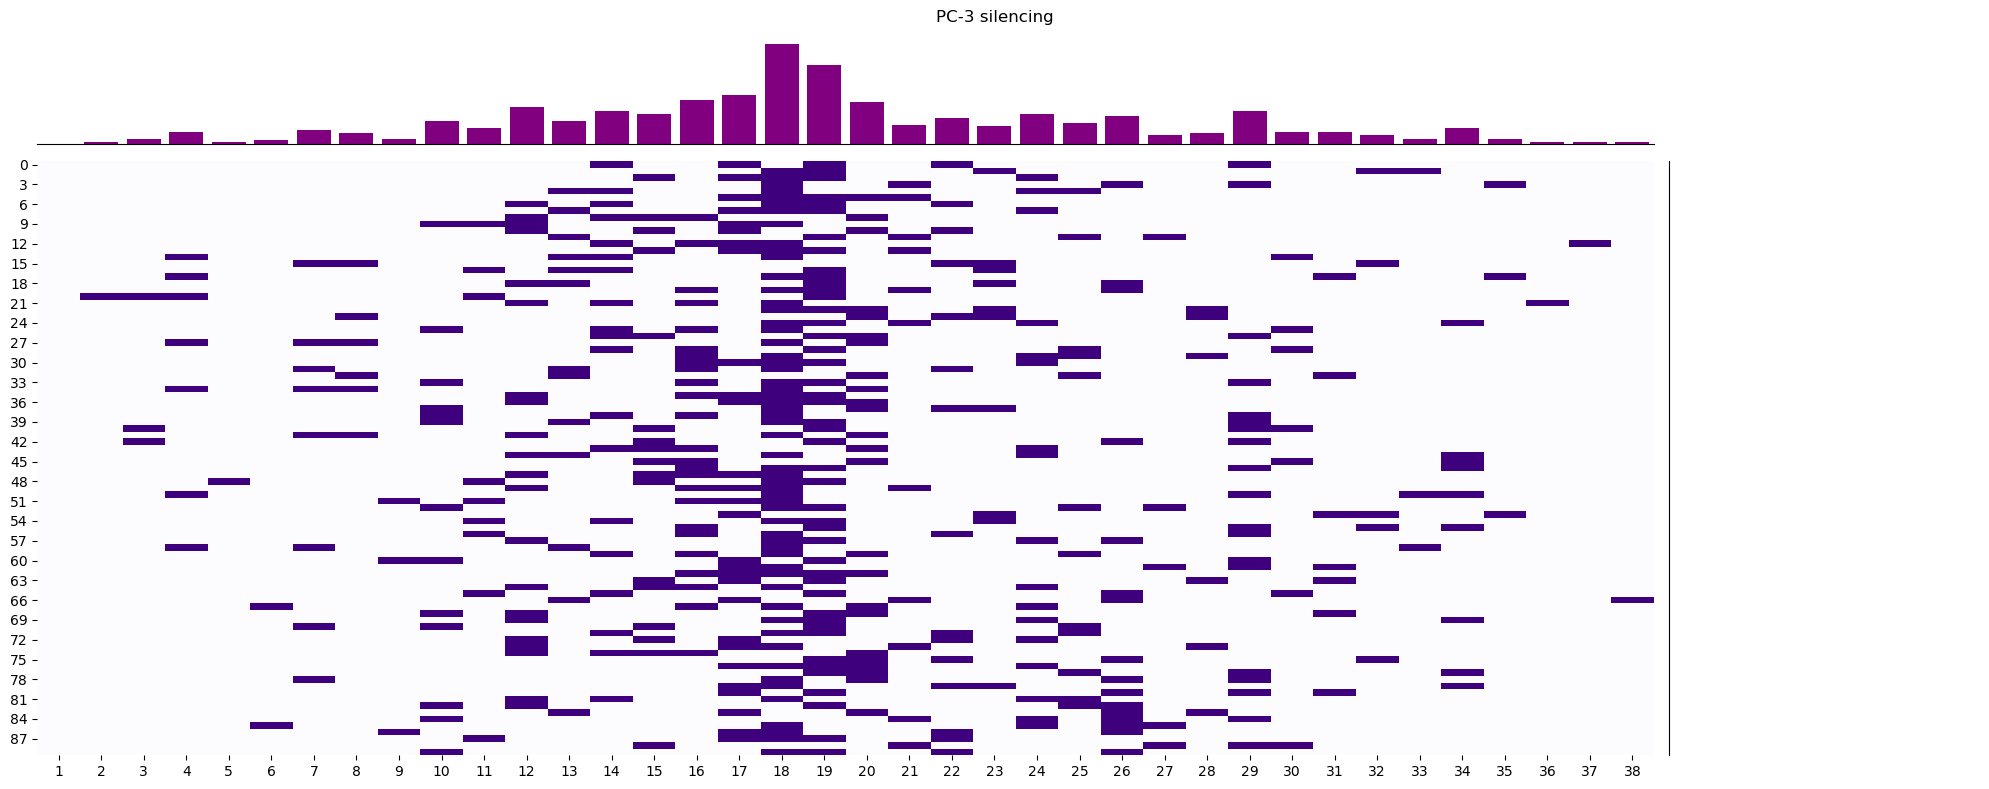

In [21]:
for (context, cell_line), context_maps in location_maps.groupby(['context', 'cell_line']):
    
    v = context_maps['tile_selected'].values.reshape((context_maps.shape[0]//38, 38))
    df = pd.DataFrame(v)
    H, D = df.shape
    df = df.reset_index(names='sequence').melt(id_vars='sequence', var_name='position', value_name='Selected')
    
    df['position'] = [int(p) for p in df['position']]
    g = sns.jointplot(data=df, x='position', y='sequence', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(data=df['Selected'].to_numpy().reshape(D, H).T.astype('float'), ax=g.ax_joint, cbar=False, cmap='Purples')
    
    # g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['position'])['Selected'].sum().to_numpy(), color='purple')
    
    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    # g.ax_joint.set_yticks(np.arange(0.5, H))
    # g.ax_joint.set_yticklabels(range(H), rotation=0)
    
    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)
    
    g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    g.fig.suptitle(f'{cell_line} {context}')
    plt.tight_layout()

    plt.savefig(f'{pdf_dir}/enhancer_distribution_{cell_line}_{context}.pdf')
    plt.show()


# Traces 

In [4]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

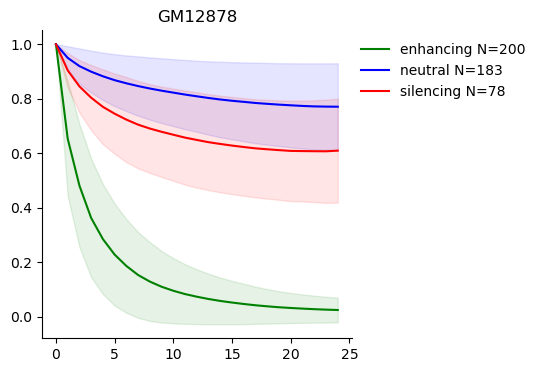

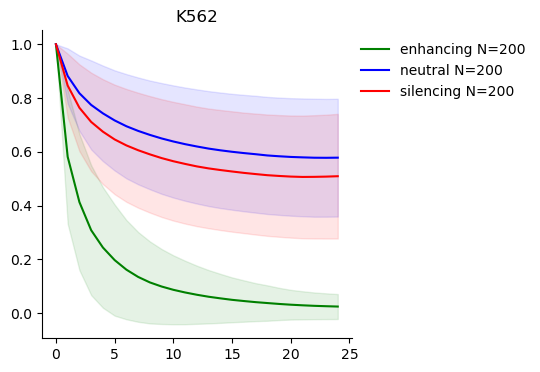

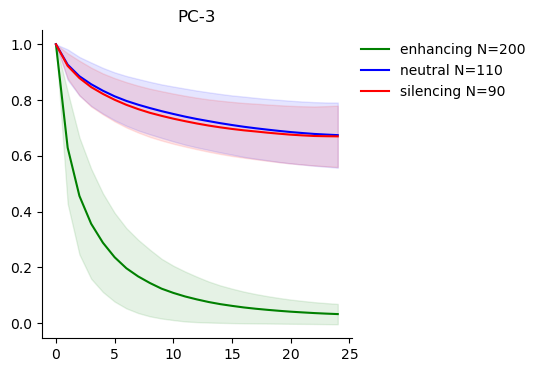

In [5]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for (cell_line), all_context_data in all_traces.groupby('cell_line'):

    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    for context, data in all_context_data.groupby('context'):
        data = data['trace'].values.reshape((data.shape[0]//N_iters, N_iters))
    
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    fig.savefig(f'{pdf_dir}/{cell_line}_enhancer_search.pdf')

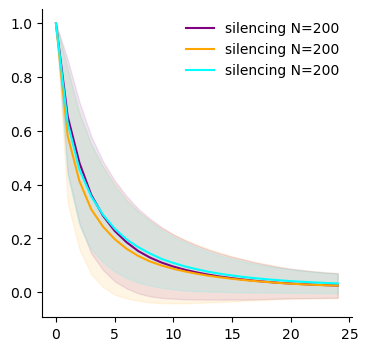

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])
colors = ['purple', 'orange', 'cyan']
for i, (cell_line, df) in enumerate(all_traces.groupby('cell_line')):
    df = df[df['context']=='enhancing']
    data = df['trace'].values.reshape((df.shape[0]//N_iters, N_iters))
  

    mean = data.mean(axis=0)
    std = data.std(axis=0)
    color = color_map[context]
    ax.plot(mean, c=colors[i], alpha=1, label=f'{context} N={data.shape[0]}')
    ax.fill_between(range(N_iters), mean-std, mean+std, alpha=0.1, color=colors[i])

    plt.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig(f"{pdf_dir}/cell_line_comparison.pdf")


# Hypothetical additive model

In [3]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

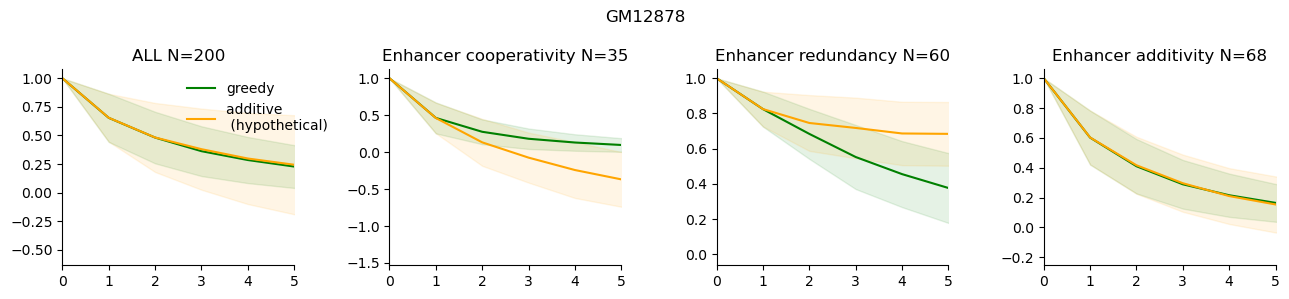

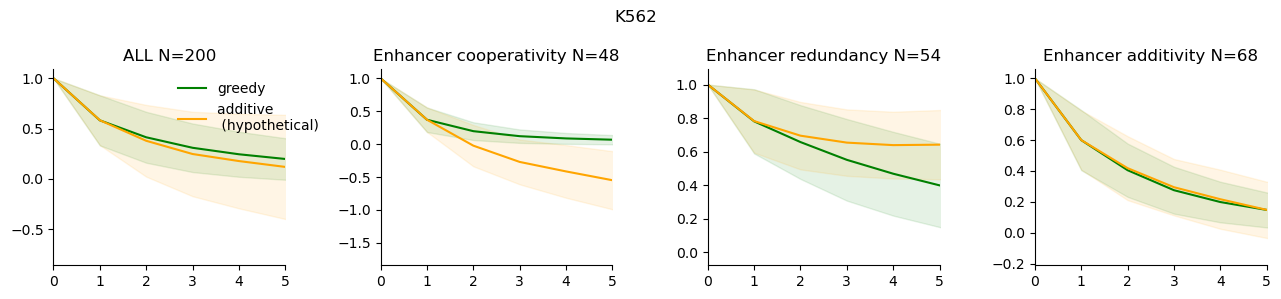

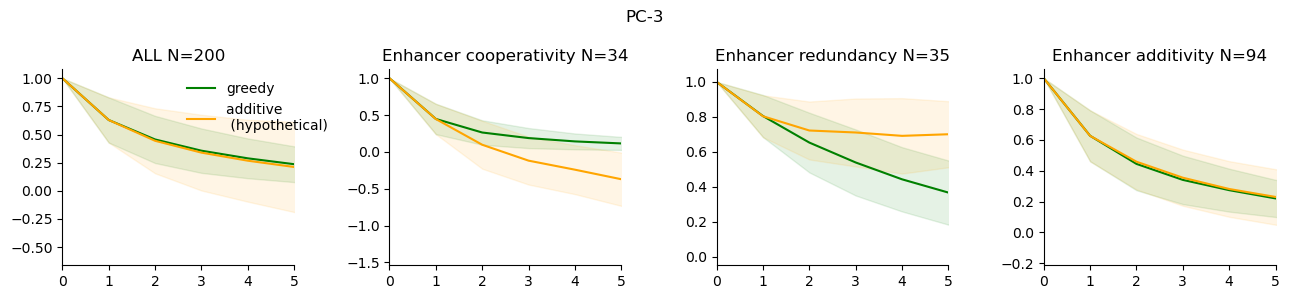

In [4]:
strata = {}
strata_seq_ids = []
for cell_line, cell_df in all_traces.groupby('cell_line'):
    sign = []
    MSE = []
    cell_enhancing_df = cell_df[cell_df['context']=='enhancing']
    L = cell_enhancing_df.shape[0]
    enhancing_greedy = cell_enhancing_df['trace'].values.reshape(L//N_iters, N_iters)
    enhancing_hyp = cell_enhancing_df['hypothetical_trace'].values.reshape(L//N_iters, N_iters)
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL', 'Enhancer cooperativity', 'Enhancer redundancy', 'Enhancer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    seq_ids = cell_enhancing_df['seq_id'].values.reshape(L//N_iters, N_iters)[:,0]
    strata[cell_line] = {'cooperativity': pos_points, 'redundancy': neg_points, 'additivity': zero_points}
    for label_stratum, point_indexes in strata[cell_line].items():
        df_per_stratum = pd.DataFrame(seq_ids[point_indexes])
        df_per_stratum.columns = ['seq_id']
        df_per_stratum['cell_line'] = cell_line
        df_per_stratum['label'] = label_stratum
        strata_seq_ids.append(df_per_stratum)
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
    curve_labels = ['greedy', 'additive \n (hypothetical)']
    
    for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
        ax = axes[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xlim(0, 5)
    axes[0].legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell_line)
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/{cell_line}_greedy_vs_additive.pdf')
strata_seq_ids = pd.concat(strata_seq_ids)

# Example sequence trajectories and sorted effect sizes


In [64]:
k562_df = all_traces[(all_traces['cell_line']=='K562') & (all_traces['context']=='enhancing')]
context_df = pd.read_csv(f'../results/summary_csvs/{model_name}/K562_selected_contexts.csv')
context_df = context_df[context_df['context']=='enhancing']

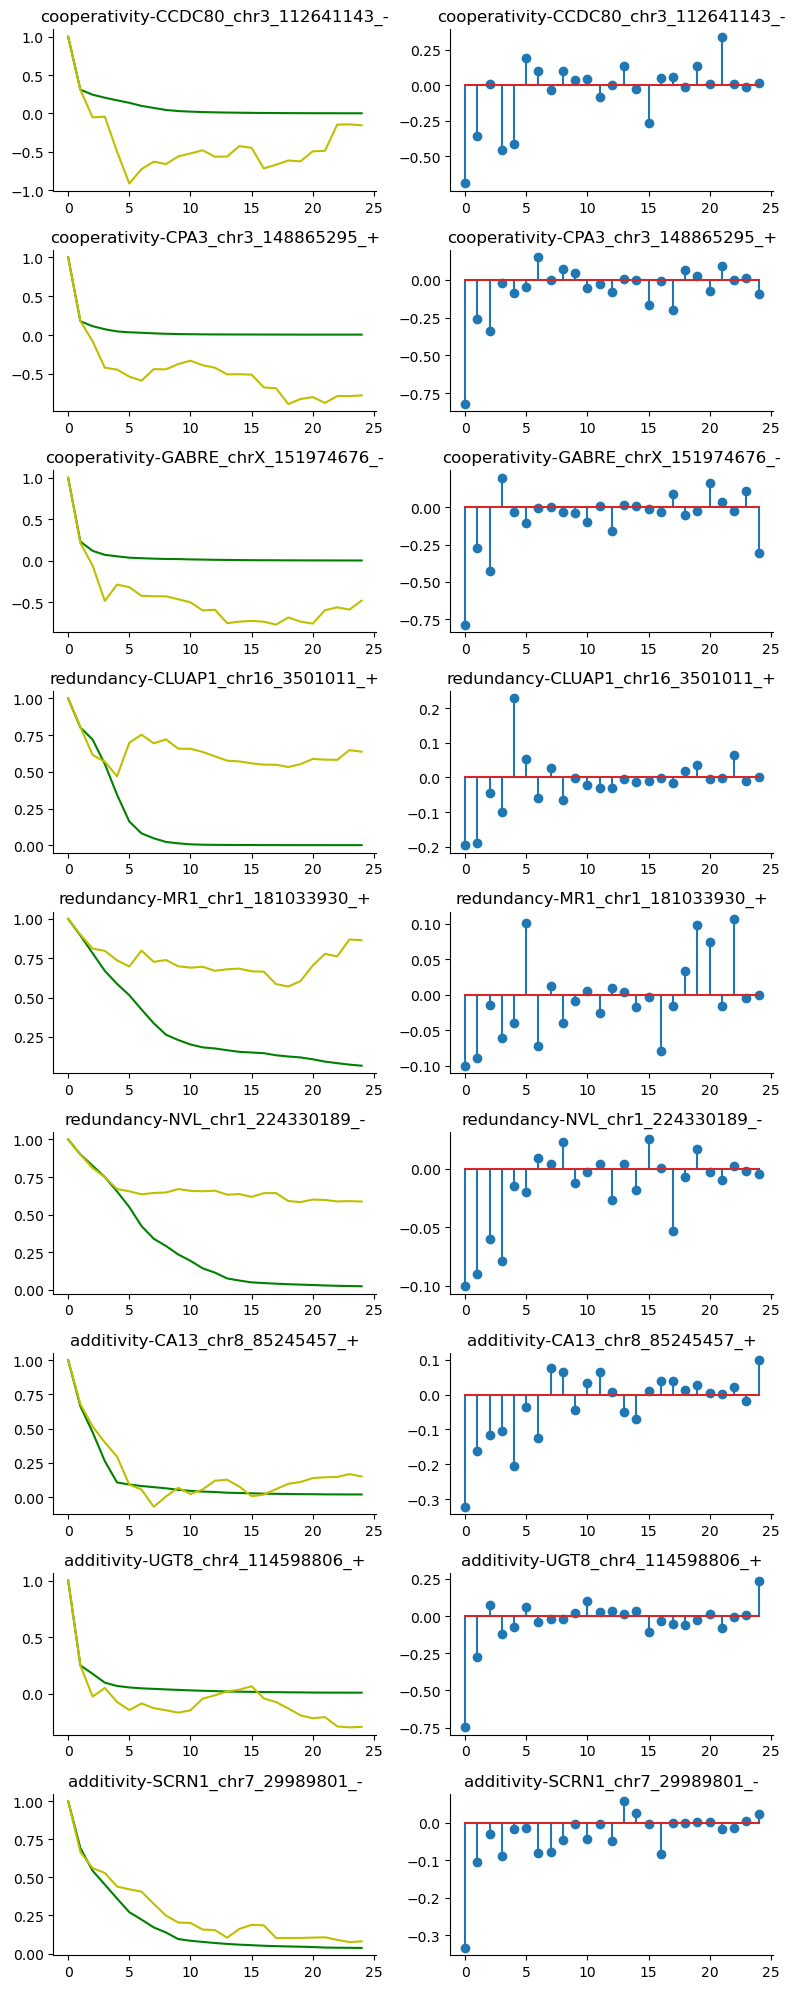

In [70]:

cell_strata = {'cooperativity': context_df['seq_id'][[126, 71, 111]].values,
              'redundancy': context_df['seq_id'][[53, 183, 15]].values,
              'additivity': context_df['seq_id'][[113, 33, 122]].values}

fig, all_axes = plt.subplots(9, 2, figsize=[8, 20])
row = 0
for label, seq_ids in cell_strata.items():
    # np.random.seed(42)
    # subset = np.random.choice(one_stratum, 10, replace=False)
    # print(label)
    for seq_id in seq_ids:
        axes = all_axes[row]
        seq_df = k562_df[k562_df['seq_id']==seq_id]
        axes[0].plot(seq_df['trace'], color='g')
        axes[0].plot(seq_df['hypothetical_trace'], color='y')
        axes[1].stem(seq_df['sorted_effects'])
        axes[0].set_title(f"{label}-{seq_id}")
        axes[1].set_title(f"{label}-{seq_id}")

        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        # plt.savefig(f"{pdf_dir}/{label}-{i}")
        # plt.show()
        row += 1
plt.tight_layout()
fig.savefig(f"{pdf_dir}/example_sequences.pdf", bbox_inches='tight')

# Hypothetical multiplicative model

In [11]:
import glob
result_summary = {}
for cell_line in cell_lines:
    cell_line_res_paths = glob.glob(f'../results/higher_order_test_min/{model_name}/{cell_line}/*pickle')
    context_df = pd.read_csv(f'../results/summary_csvs/{model_name}/{cell_line}_selected_contexts.csv')
    traces = {k:[] for k in context_df['context'].unique()}
    hypothetical_traces = {k:[] for k in context_df['context'].unique()}
    for _, row in context_df.iterrows():
        res_path = f"../results/higher_order_test_min/{model_name}/{cell_line}/{row['path'].split('/')[-1]}"
        raw_res = utils.read_pickle(res_path)
        res = {}
        for i in raw_res.keys():
            res[i] = {}
            
            for k, v in raw_res[i].items():
                if 'pred' in k:
                    res[i][k] = np.log(v) 
                else:
                    res[i][k] = v
        wt = res[0]['initial_pred']
        traces[row['context']].append([res[i]['initial_pred']/wt for i in res.keys()])
        ####hypothetical additive model
        greedy_search_order = [np.argwhere(np.array(cre_tiles) == res[i]['selected_tile'])[0][0] for i in res.keys()]
        mutant_predictions_first_iter = res[0]['preds'].mean(axis=-1)
        
        effect_sizes_first_iter = mutant_predictions_first_iter - wt
        sorted_effect_first_iter = effect_sizes_first_iter[greedy_search_order]
        sum_of_effects = np.cumsum(sorted_effect_first_iter) 
        hypothetical_trace = wt + sum_of_effects
        hypothetical_trace = np.concatenate([[wt], hypothetical_trace]) / wt
        
        hypothetical_traces[row['context']].append(hypothetical_trace[:-1])
    result_summary[cell_line] = {'greedy search': traces, 'hypothetical multiplicative': hypothetical_traces}

In [189]:
df

,trace,hypothetical_trace,sorted_effects,log_trace,log_hypothetical_trace,log_sorted_effects,cell_line_x,context,seq_id,cell_line_y,label
125,1.000000,1.000000,-0.155624,1.000000,1.000000,-0.054406,PC-3,enhancing,CARD8_chr19_48255946_-,PC-3,redundancy
126,0.847887,0.844376,-0.133852,0.947242,0.945594,-0.046021,PC-3,enhancing,CARD8_chr19_48255946_-,PC-3,redundancy
127,0.735942,0.710524,-0.082947,0.901970,0.899572,-0.027779,PC-3,enhancing,CARD8_chr19_48255946_-,PC-3,redundancy
128,0.648185,0.627577,0.029538,0.861372,0.871794,0.009270,PC-3,enhancing,CARD8_chr19_48255946_-,PC-3,redundancy
129,0.581998,0.657114,-0.007607,0.826934,0.881064,-0.002941,PC-3,enhancing,CARD8_chr19_48255946_-,PC-3,redundancy
...,...,...,...,...,...,...,...,...,...,...,...
7195,0.054102,0.599675,0.008088,0.223063,0.882454,0.002138,PC-3,enhancing,TOP3B_chr22_21982787_-,PC-3,redundancy
7196,0.050619,0.607763,0.030201,0.205338,0.884592,0.007905,PC-3,enhancing,TOP3B_chr22_21982787_-,K562,redundancy
7197,0.050619,0.607763,0.030201,0.205338,0.884592,0.007905,PC-3,enhancing,TOP3B_chr22_21982787_-,PC-3,redundancy
7198,0.045786,0.637965,-0.004072,0.178607,0.892497,-0.001088,PC-3,enhancing,TOP3B_chr22_21982787_-,K562,redundancy


In [193]:
df[label].values.reshape(1275//25, 25)

array([[ 1.        ,  0.947242  ,  0.9019698 , ...,  0.00720829,
        -0.02423279, -0.05403899],
       [ 1.        ,  0.97478026,  0.9563785 , ...,  0.4459659 ,
         0.41253713,  0.38649178],
       [ 1.        ,  0.87272245,  0.858604  , ...,  0.6109683 ,
         0.5977383 ,  0.5859254 ],
       ...,
       [ 1.        ,  0.95151085,  0.911497  , ...,  0.45779425,
         0.44715637,  0.4371142 ],
       [ 1.        ,  1.        ,  0.9491323 , ...,  0.5373098 ,
         0.5373098 ,  0.51019496],
       [ 0.51019496,  0.48766685,  0.48766685, ...,  0.20533764,
         0.17860734,  0.17860734]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


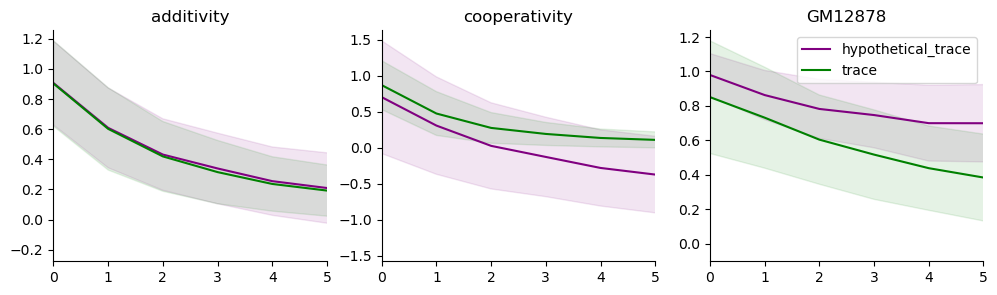

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


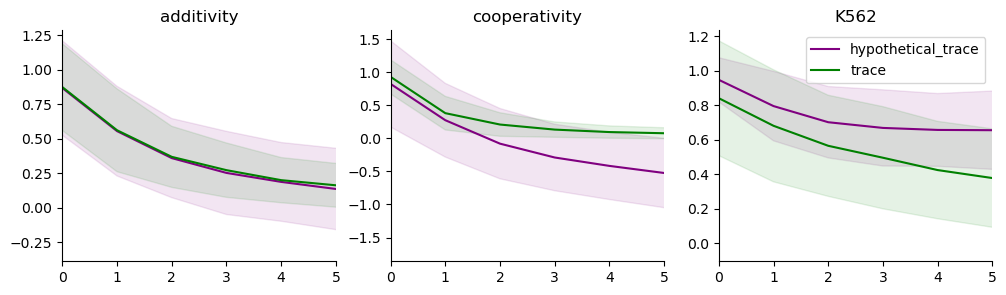

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


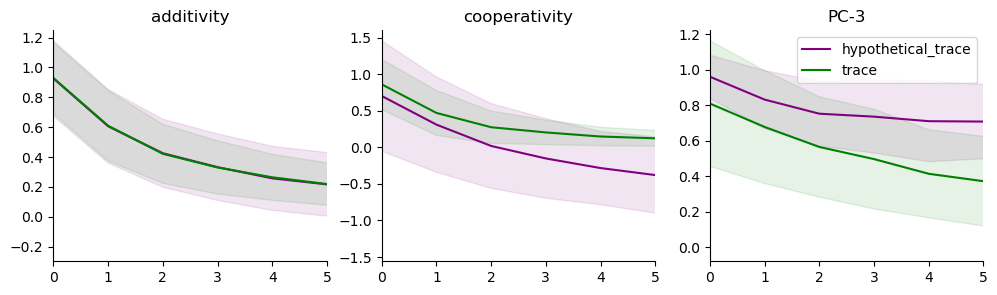

In [6]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')
colors = ['purple', 'green']
for cell_line, cell_line_df in all_traces.merge(strata_seq_ids, on='seq_id').groupby('cell_line_x'):
    fig, axes = plt.subplots(1, 3, figsize=[12, 3])
    for g, (group, df) in enumerate(cell_line_df.groupby('label')):
        ax = axes[g]
        N = df.shape[0]
        for l, label in enumerate(['hypothetical_trace', 'trace']):
            x = df[label].values.reshape(N//N_iters, N_iters)
            
            mean = x.mean(axis=0)
            std = x.std(axis=0)
            ax.plot(mean, c=colors[l], label=label)
            ax.fill_between(range(N_iters), mean-std, mean+std, alpha=0.1, color=colors[l])
        plt.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(group)
        ax.set_xlim(0, 5)
    plt.title(cell_line)
    plt.show()

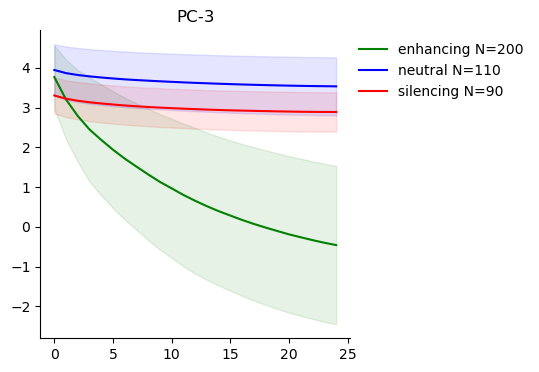

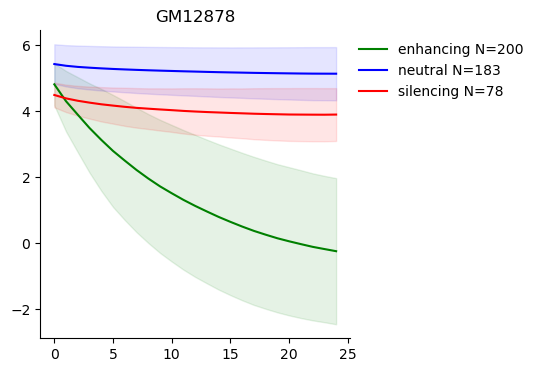

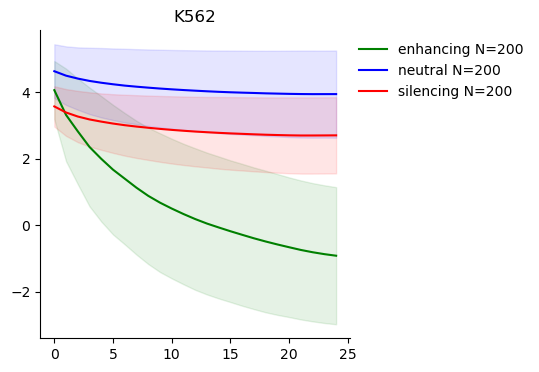

In [85]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for cell_line in cell_lines:


    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    
    for context, data in result_summary[cell_line]['greedy search'].items():
        data = np.array(data)
        
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    plt.show()

# 2nd point comparison


In [84]:
second_it_all = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_second_iteration.csv', index_col='Unnamed: 0')

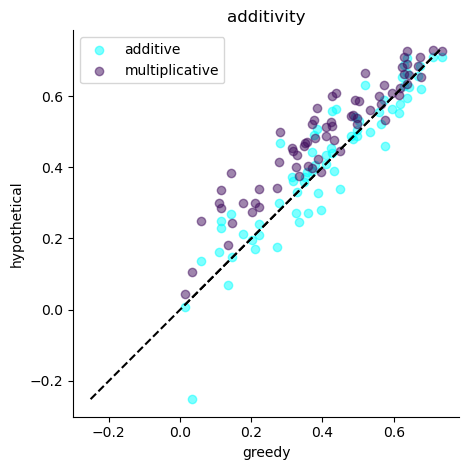

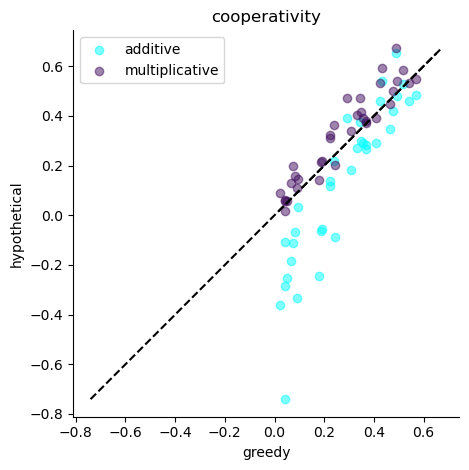

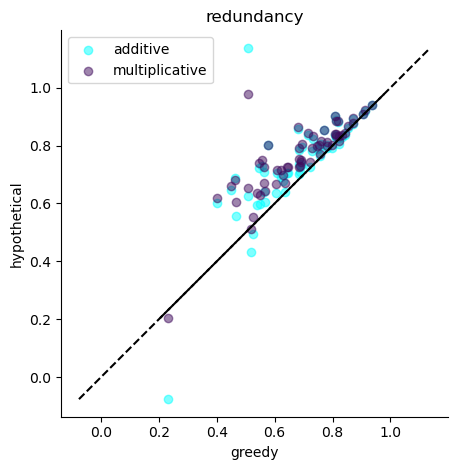

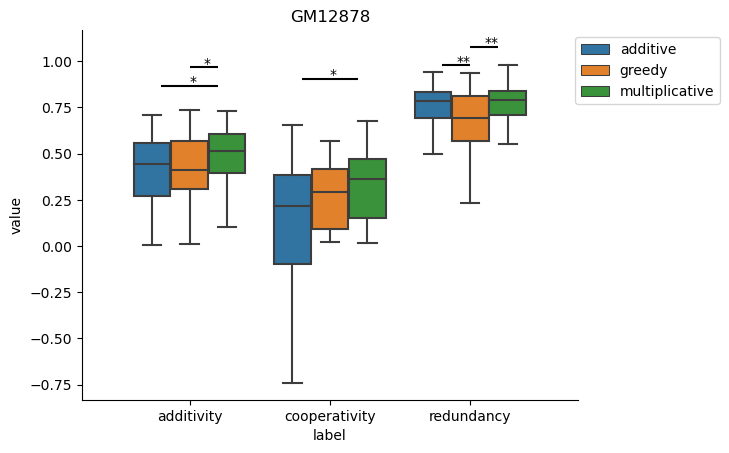

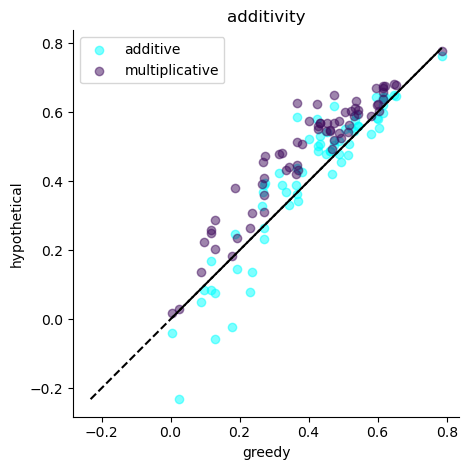

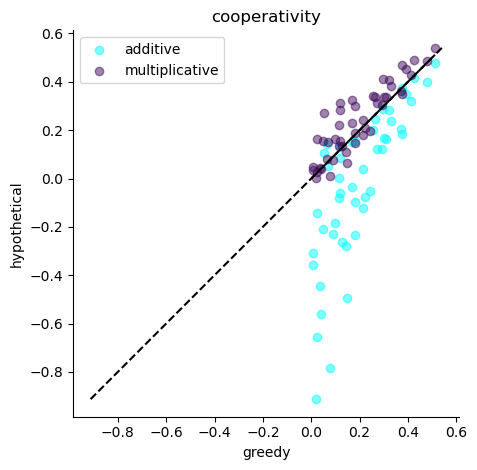

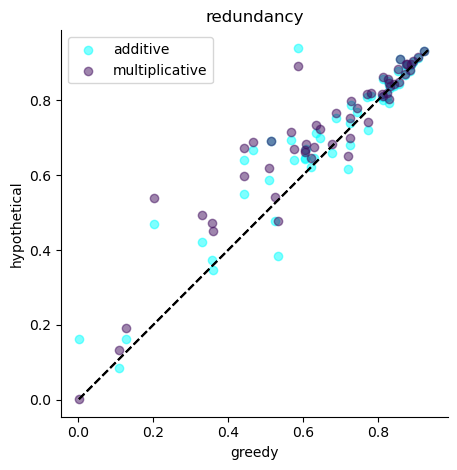

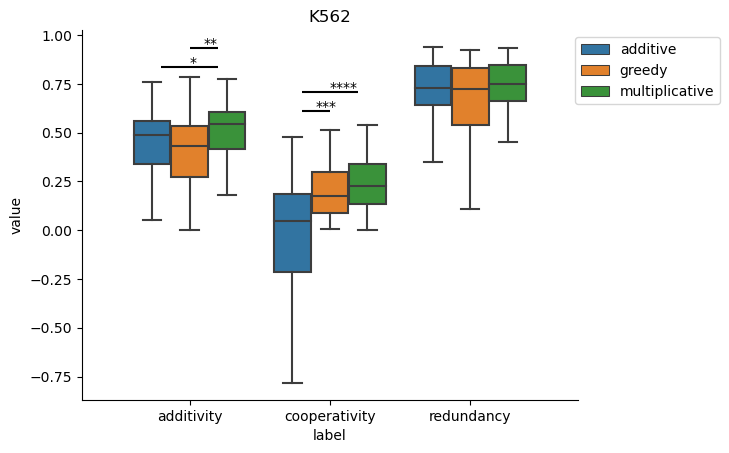

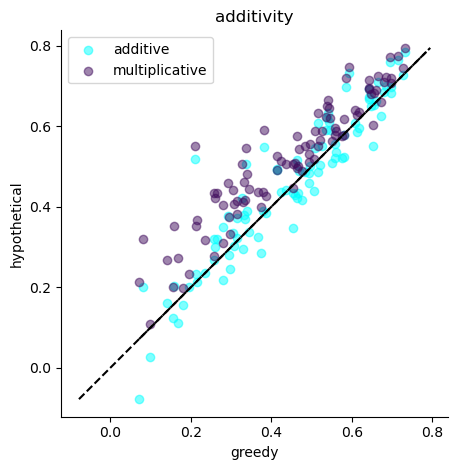

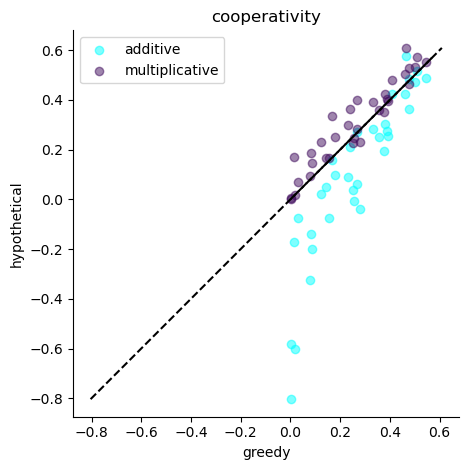

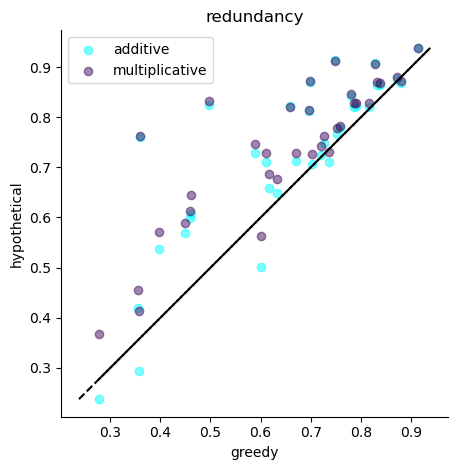

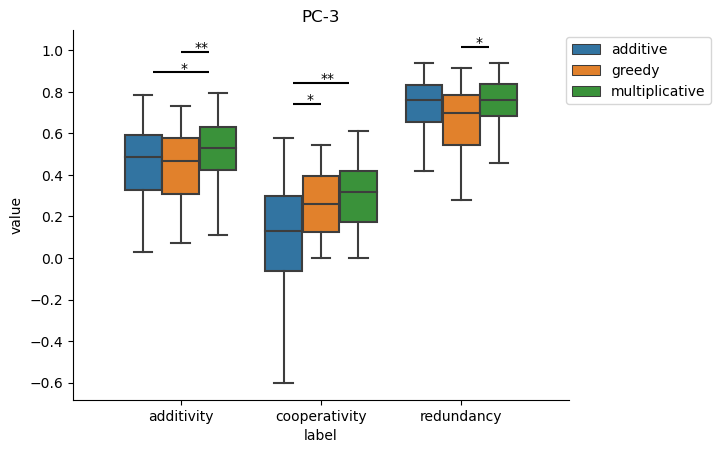

In [177]:
order=['additivity', 'cooperativity', 'redundancy']
hue_order=['additive', 'greedy', 'multiplicative']

for cell_line, df_cell_line in second_it_all.groupby('cell_line'):
    
    context = 'enhancing'
    df_cell_line = df_cell_line[df_cell_line['context']==context]
    hypothetical_additive = []
    hypothetical_multiplicative = []
    greedy = []
    seq_ids = []
    for d, (_, data_point) in enumerate(df_cell_line.groupby('seq_id')):
        assert data_point.shape == (4, 4), 'Bad dataframe shape'
        wt, p1, p2, greedy_res = (data_point.iloc[:, 0].values)
        log_wt, log_p1, log_p2, _ = [np.log(i) for i in data_point.copy().iloc[:,0].values]
        hypothetical_additive.append((wt + (p1 - wt) + (p2 - wt))/wt)
        hypothetical_multiplicative.append((np.exp(log_wt + (log_p1 - log_wt) + (log_p2 - log_wt)))/wt)
        greedy.append(greedy_res/wt)
        seq_ids.append(data_point['seq_id']['wt'])
    df = pd.DataFrame([hypothetical_additive, hypothetical_multiplicative, greedy, seq_ids]).T
    df.columns = ['additive', 'multiplicative', 'greedy', 'seq_id']
    strata_ids = strata_seq_ids[strata_seq_ids['cell_line']==cell_line]
    df = df.merge(strata_ids, on='seq_id')
    data=df[['additive', 'multiplicative', 'greedy', 'label']].melt(value_vars=['additive', 'multiplicative', 'greedy'], 
                                                               id_vars='label')
    # sns.boxplot(data=data,
    #        x='label', y='value', showfliers=False,
    #             order=order,
    #             hue='variable', hue_order=hue_order)
    # plt.title(cell_line)
    # plt.show()
    

    annotations = []
    for s_i, stratum in enumerate(order):
        df_stratum = df[df['label']==stratum]  
        y_counter = 0
        for p, pair_index in enumerate(list(itertools.combinations(range(3), 2))):

            
            model_type1, model_type2 = hue_order[pair_index[0]], hue_order[pair_index[1]]
            p_sign = utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df_stratum[model_type1].astype(float), 
                                                                                df_stratum[model_type2].astype(float))[1])
            if p_sign!= 'ns':
                

                Q1 = np.quantile(df_stratum['multiplicative'], 0.25)
                Q3 = np.quantile(df_stratum['multiplicative'], 0.75)
                    
                IQR = Q3 - Q1
                lim = Q3 + 1.5 * IQR
                annotations.append([s_i-0.2, y_counter, pair_index, p_sign, lim*1.05])
                y_counter += 0.1
        fig, ax = plt.subplots(1, 1)
        
        for p, (x, y) in enumerate([['greedy', 'additive'], ['greedy', 'multiplicative']]):

            
        
            ax.set_aspect('equal', adjustable='box')
            ax.scatter(df_stratum[x], df_stratum[y],color=['cyan', '#400c5d'][p], label=y, alpha=0.5)
            ax.set_xlabel(x)
            ax.set_ylabel('hypothetical')
            # ax.set_ylabel(y)

            # sns.scatterplot(data=df_stratum, x=x, y=y, edgecolor=None, alpha=0.3, color="#400c5d", ax=ax)
            min_point, max_point = df_stratum[[x, y]].min().min(), df_stratum[[x, y]].max().max()
            ax.plot([min_point, max_point], [min_point, max_point], color='k', linestyle='--')
            ax.set_title(stratum)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        plt.legend()
        plt.tight_layout()
        plt.show()

    ax=sns.boxplot(data=data, x='label', y='value', showfliers=False, 
                   hue='variable',
                order=order, hue_order=hue_order)
    # plt.title(f"{cell_line} {context}")
    for (s_i, y_counter, pair_index, p_sign, y_max) in annotations:
        x1, x2 = s_i+pair_index[0]*0.2, s_i+pair_index[1]*0.2
        y = y_max*0.9+y_counter
        plt.hlines(y, x1, x2, color='k')
        plt.annotate(p_sign, ((x1+x2)/2, y))
    plt.title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(bbox_to_anchor=[1.3, 1])



    plt.show()
